# 1.1) Source Code

In [35]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

### 데이터 준비

In [36]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [37]:
# 데이터 살펴보기
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [38]:
# 데이터 살펴보기
test.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

***

### 데이터 전처리

<AxesSubplot:>

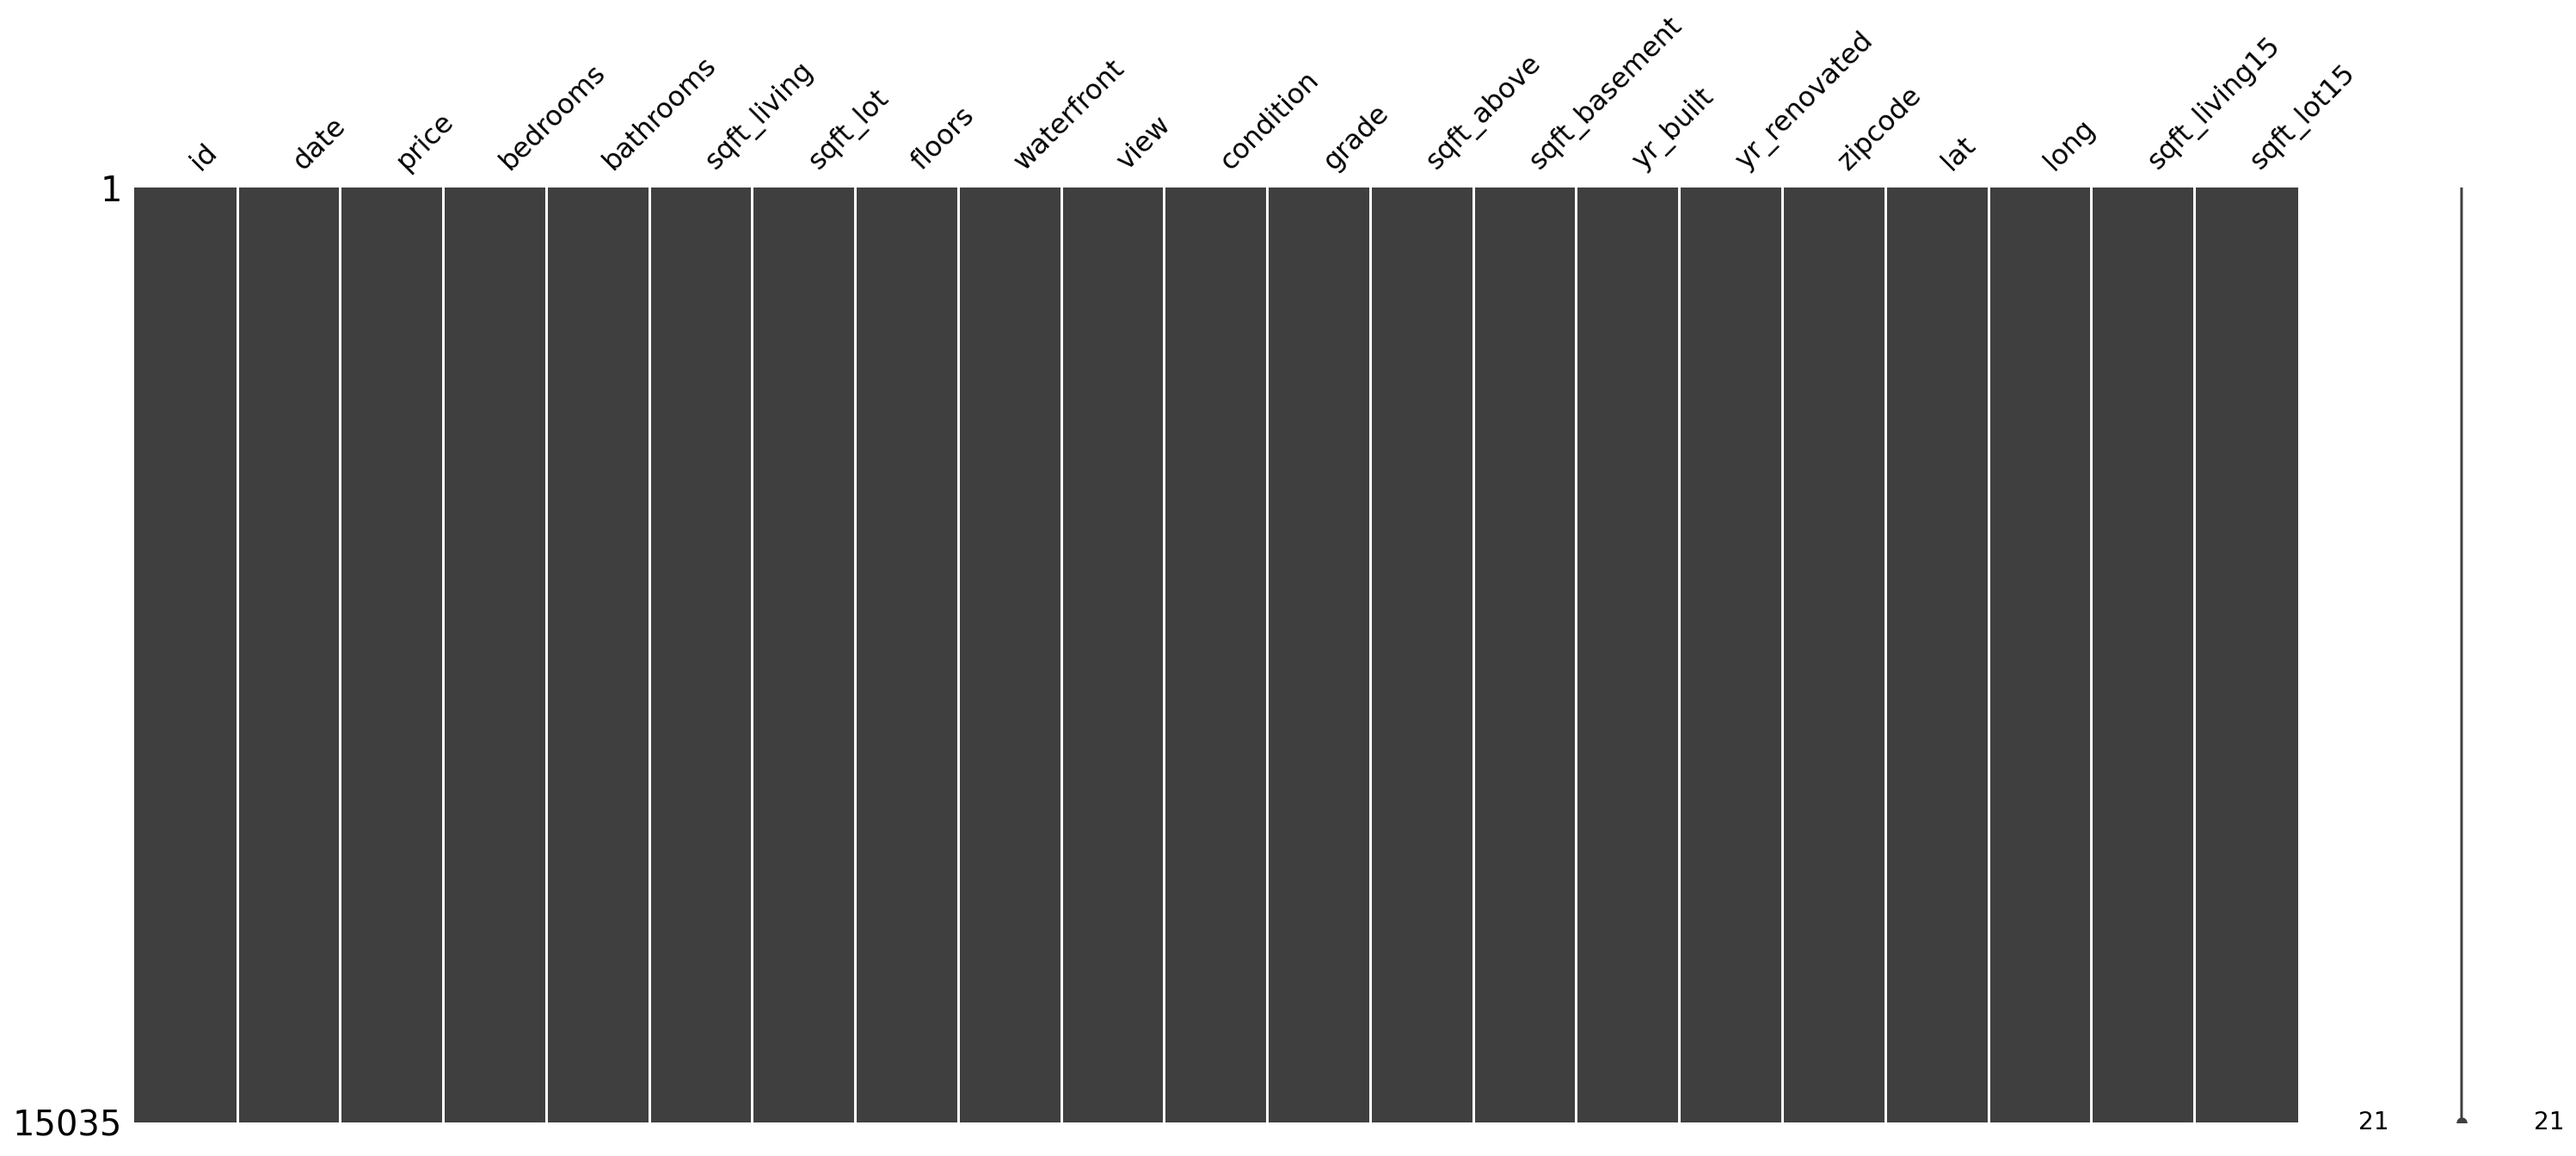

In [39]:
# train data 의 결측값 확인
msno.matrix(train)

<AxesSubplot:>

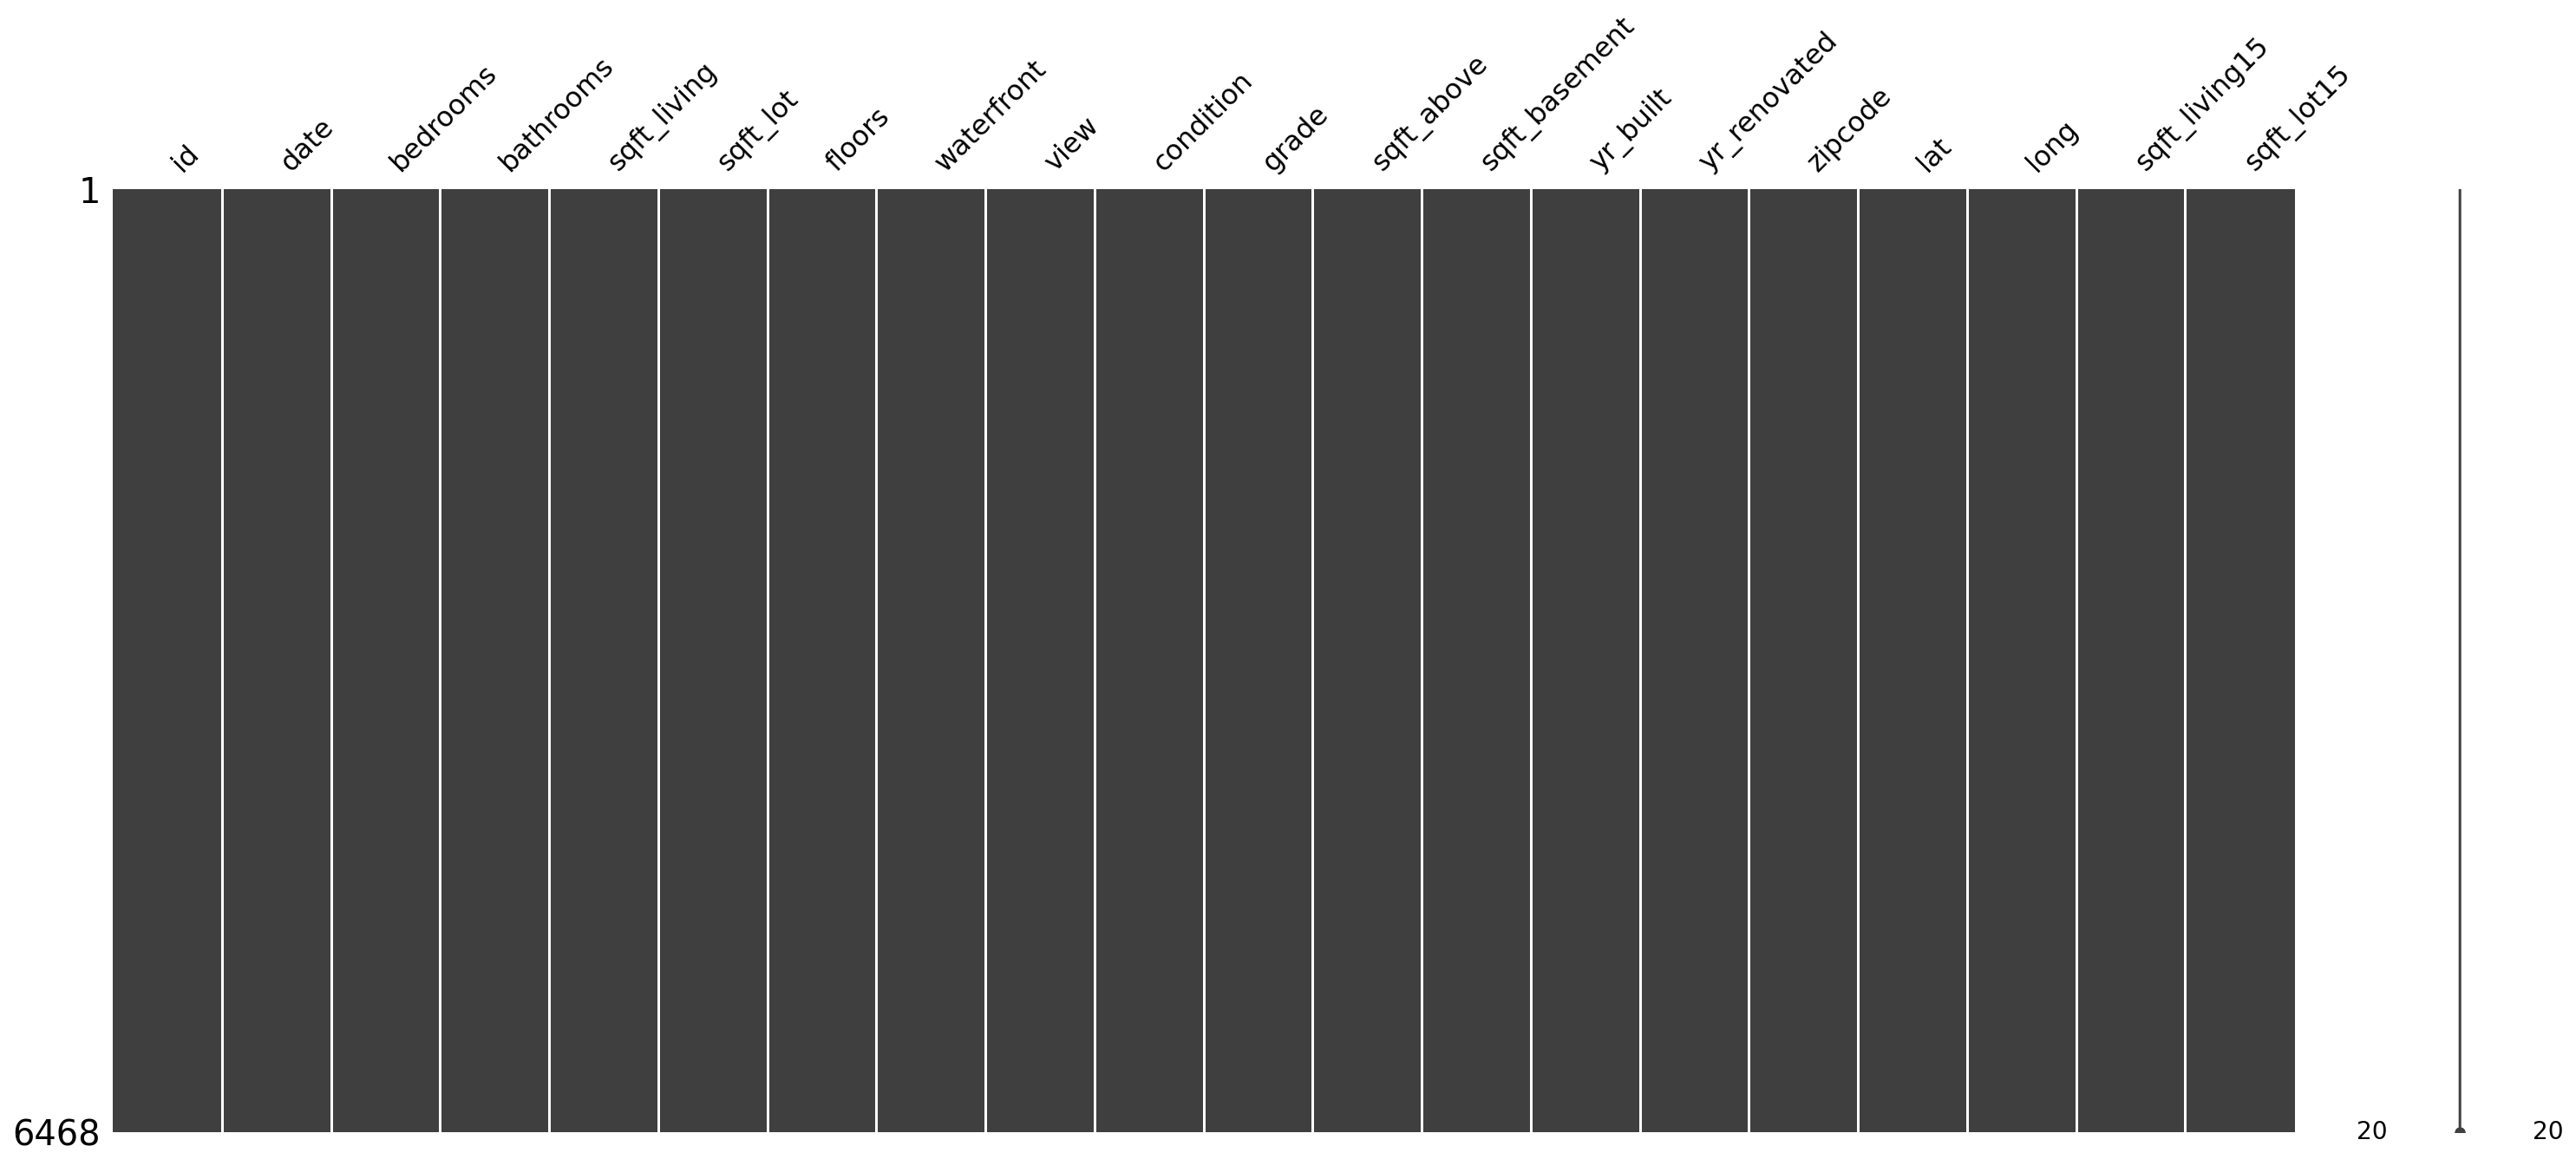

In [40]:
# test data 의 결측값 확인
msno.matrix(test)

- msno.matrix() 를 활용하여 각 데이터의 결측값을 확인해보았습니다.

In [41]:
# train data 의 결측값 확인_2
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [42]:
# test data 의 결측값 확인_2
for c in test.columns:
    print('{} : {}'.format(c, len(test.loc[pd.isnull(test[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


- 위와 같은 방법으로도 각 데이터의 결측치를 확인할 수 있습니다.

In [43]:
# target data 에 해당하는 y 를 선언
y = train['price']
# train data 에서 price 컬럼 삭제
del train['price']

# Test
print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- price 컬럼은 예측할 데이터이므로, y 에 따로 담아줍니다.
- 그 후, train data 에서는 price 컬럼을 삭제해주었습니다.

In [44]:
train['date'] = train['date'].apply(lambda x: x[:6]).astype(int)
train.head()

id    date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0   0  201410         3       1.00         1180      5650     1.0           0   
1   1  201502         2       1.00          770     10000     1.0           0   
2   2  201502         3       2.00         1680      8080     1.0           0   
3   3  201406         3       2.25         1715      6819     2.0           0   
4   4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

- date 컬럼을 연도와 월로 자르고, 학습에 사용하기 위해 int 형으로 변환해주었습니다.

In [45]:
del train['id']

# Test
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- id 컬럼은 각 데이터를 구분하는 고유번호이므로, 예측값과는 무관하여 삭제해주었습니다.

In [46]:
test['date'] = test['date'].apply(lambda x: x[:6]).astype(int)

del test['id']

# Test
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


- test data 또한, date 컬럼을 동일하게 전처리해주고, id 컬럼을 삭제해주었습니다.
- test data 에는 price 컬럼이 담겨있지 않습니다.

In [47]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

- y 데이터를 살펴보겠습니다.

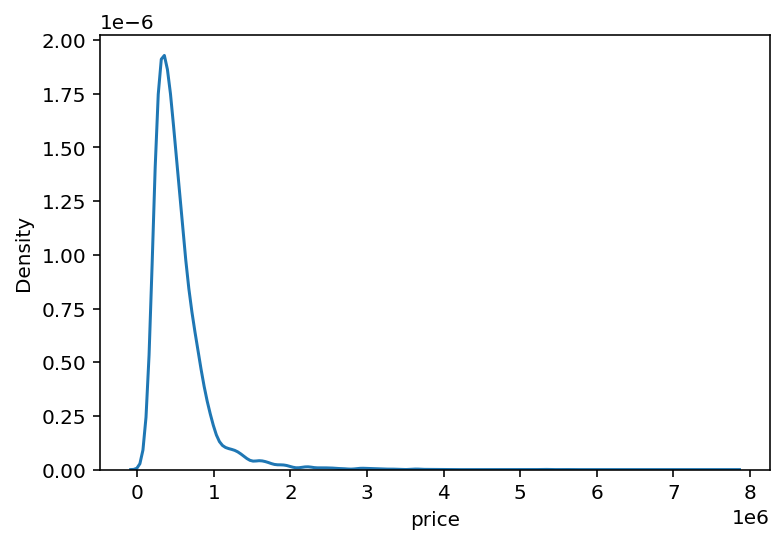

In [48]:
# y data 분포 확인
sns.kdeplot(data=y)
plt.show()

- y 데이터의 분포가 고르지 못한 것을 직관적으로 확인할 수 있습니다.

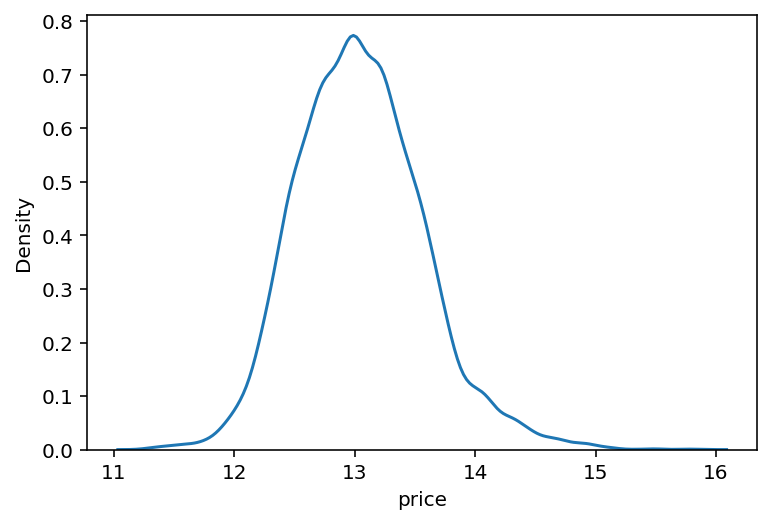

In [49]:
# y data 에 log 를 취해 분포도를 조정
y = np.log1p(y)

# log 를 취한 y data 분포 확인
sns.kdeplot(y)
plt.show()

- np.log1p() 를 취하여 값의 분포가 비교적 완만한 정규분포로 바뀌었음을 확인할 수 있습니다.

In [50]:
# 전체 데이터의 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

- 모든 컬럼이 int 혹은 float 이므로, 모델을 학습시킬 수 있게 되었습니다.

***

### 하이퍼 파라미터 및 모델링

In [51]:
# Model 선언
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [52]:
# Hyper-Parameter
param_grid = {'n_estimators': [50, 100],
              'max_depth': [1, 10]}

- Grid Search 를 통해 최적의 Hyper-Parameter 를 찾아보겠습니다.
- Grid Search 를 위한 Hyper-Parameter 값의 범위를 지정해줍니다.

In [53]:
# LightGBM(lgbm) Model 준비
model = LGBMRegressor(random_state=2019)

- 모델은 LGBMRegressor 를 사용하도록 하겠습니다.

In [94]:
# Model_name
model_name = model.__class__.__name__
model_name

'LGBMRegressor'

- 모델 이름을 변수에 저장합니다.

In [55]:
# Grid Searching
grid_model = GridSearchCV(model, param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5, verbose=1, n_jobs=5)

# Finding Hyper-Parameters
grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2019), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

- GridSearchCV 에 앞서 정의해준 LGBMRegressor 와 param_grid 를 넣어 모델을 생성해주었습니다.
- scoring 은 neg_mean_squared_error 를 사용하며, cross-validation 은 5 로 선언해주었습니다.
- 앞서 정의한 param_grid 에서 알 수 있듯이, 가능한 조합의 개수는 4 개 입니다.
- cross-validation 이 5 이므로, 각 조합마다 5 번의 작업을 수행하게 되며, 총 20 번의 fitting 을 진행하게 됩니다.

In [56]:
# Results
grid_model.cv_results_

{'mean_fit_time': array([0.19217663, 0.18702044, 0.33399796, 0.57137179]),
 'std_fit_time': array([0.06525708, 0.00309643, 0.00916907, 0.12592795]),
 'mean_score_time': array([0.01190391, 0.010531  , 0.01804605, 0.04064856]),
 'std_score_time': array([0.00585682, 0.00016313, 0.00150622, 0.01513022]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

- Grid Search 의 결과를 출력합니다.

In [57]:
# Summary
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

print("params: {}".format(params))
print("score: {}".format(score))

params: [{'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]
score: [-0.07339447 -0.05502043 -0.02917734 -0.02702714]


- 위 결과에서 중요한 지표는 'max_depth' 와 'n_estimators', 'score' 입니다.

In [58]:
# 각 조합별 점수 dataframe
df_results = pd.DataFrame(params)
df_results['score'] = score

df_results

max_depth  n_estimators     score
0          1            50 -0.073394
1          1           100 -0.055020
2         10            50 -0.029177
3         10           100 -0.027027

- 결과를 직관적으로 확인하기 위해 DataFrame 으로 표현해주었습니다.

In [59]:
# RMSLE 를 추가한 dataframe
df_results['RMSLE'] = np.sqrt(-1 * df_results['score'])
df_results

max_depth  n_estimators     score     RMSLE
0          1            50 -0.073394  0.270914
1          1           100 -0.055020  0.234564
2         10            50 -0.029177  0.170814
3         10           100 -0.027027  0.164399

- log 를 취한 y 값에 대해 exp 로 복원하지 않고 오차를 계산하였으므로 RMSLE 가 될 것입니다.

In [60]:
# RMSLE 오름차순 정렬
df_results = df_results.sort_values(by=['RMSLE'])
df_results

max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

In [61]:
# 위의 과정들을 함수로 정의
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # grid_search_model 생성
    grid_model = GridSearchCV(model, param_grid=param_grid,
                              scoring='neg_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # model fitting
    grid_model.fit(train, y)
    
    # model 결과값을 dataframe 으로 생성
    df_results = pd.DataFrame(grid_model.cv_results_['params'])
    df_results['score'] = grid_model.cv_results_['mean_test_score']
    
    # RMSLE 생성 후 정렬
    df_results['RMSLE'] = np.sqrt(-1 * df_results['score'])
    df_results = df_results.sort_values(by='RMSLE')
    
    return df_results

- 모델과 파라미터 범위를 인자로 받아 Grid Search 를 자동화하여 결과를 DataFrame 으로 반환하는 함수를 정의하였습니다.

In [62]:
# Grid Searching
param_grid = {'n_estimators': [50, 100],
              'max_depth': [1, 10]}

model = LGBMRegressor(random_state=2019)
my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


max_depth  n_estimators     score     RMSLE
3         10           100 -0.027027  0.164399
2         10            50 -0.029177  0.170814
1          1           100 -0.055020  0.234564
0          1            50 -0.073394  0.270914

***

### Test data 학습 및 예측

In [63]:
# 찾아낸 Hyper-Parameter 를 적용하여 학습 후 예측
model = LGBMRegressor(max_depth=10, n_estimators=100, 
                      random_state=2019)

model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

- 앞서 찾아낸 최적의 Hyper-Parameter 를 적용하여 LGBMRegressor 모델을 생성하였습니다.
- 모델을 학습시킨 후, test 데이터에 대한 예측을 수행합니다.

In [64]:
# 예측값을 exp 로 변환
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

- prediction 에 np.expm1 을 취해 변환해주면, 저희가 찾고자 하는 예측값을 도출할 수 있습니다.

***

### 예측한 결과를 csv 파일로 저장

In [65]:
# sample_submission.csv
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

- sample_submission.csv 파일을 불러옵니다.

In [66]:
# prediction 을 sample_submission 의 'price' 컬럼에 덮어씌우기
submission['price'] = prediction
submission.head()

id         price
0  15035  5.067667e+05
1  15036  4.795061e+05
2  15037  1.345155e+06
3  15038  3.122579e+05
4  15039  3.338645e+05

- sample_submission.csv 의 price 컬럼에 앞서 예측한 prediction 을 붙여넣습니다.

In [68]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, 0.164399)
submission.to_csv(submission_csv_path, index=False)
    
print('{} saved!'.format(submission_csv_path))

/aiffel/aiffel/kaggle_kakr_housing/data/submission_LGBMRegressor_RMSLE_0.164399.csv saved!


In [70]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    
    print('{} saved!'.format(submission_csv_path))

- 모델과 데이터, 모델이름과 RMSLE 를 인자로 받아 모델 학습 및 예측 후, 결과를 csv 파일로 저장하는 과정을 자동화하는 함수입니다.

# 1.2) Source Code

### 데이터 준비

In [65]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [66]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [67]:
test.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

In [68]:
print("train.shape:", train.shape)
print("test.shape:", test.shape)

train.shape: (15035, 21)
test.shape: (6468, 20)


***

### 데이터 전처리

In [69]:
del train['id']
del test['id']

# Test
print("train.shape:", train.shape)
print("test.shape:", test.shape)

train.shape: (15035, 20)
test.shape: (6468, 19)


- 1.1) 과 동일하게 id 컬럼을 삭제해주겠습니다.

In [70]:
y = train['price']
del train['price']

# Test
print("train.shape:", train.shape)
print("y.shape:", y.shape)

train.shape: (15035, 19)
y.shape: (15035,)


- target 값을 y 변수에 따로 저장해두고 train 에서는 삭제해주었습니다.

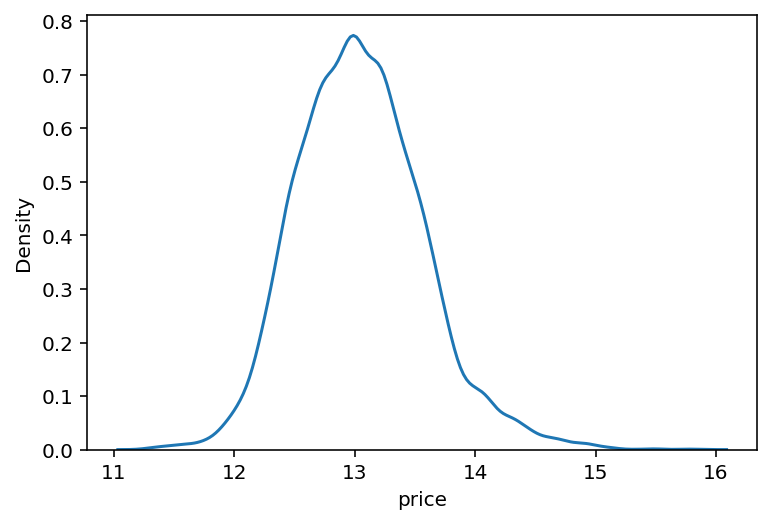

In [71]:
y = np.log1p(y)

# Visualization
sns.kdeplot(y)
plt.show()

- 1.1) 과 동일하게 price 값의 정규성을 log 를 취해 조정해주었습니다.

In [72]:
train['date'] = train['date'].apply(lambda x: x[:8]).astype(int)
test['date'] = test['date'].apply(lambda x: x[:8]).astype(int)

In [73]:
# Test
train.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  20141013         3       1.00         1180      5650     1.0           0   
1  20150225         2       1.00          770     10000     1.0           0   
2  20150218         3       2.00         1680      8080     1.0           0   
3  20140627         3       2.25         1715      6819     2.0           0   
4  20150115         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

In [74]:
# Test
test.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  20141209         3       2.25         2570      7242     2.0           0   
1  20141209         4       3.00         1960      5000     1.0           0   
2  20140512         4       4.50         5420    101930     1.0           0   
3  20150415         3       1.00         1780      7470     1.0           0   
4  20150312         3       2.50         1890      6560     2.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        2170            400      1951          1991   
1     0          5      7        1050            910      1965             0   
2     0          3     11        3890           1530      2001             0   
3     0          3      7        1050            730      1960             0   
4     0          3      7        1890              0      2003             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98125  47.7210 -122.319           1690        7639  
1    98136  47.5208 -122.393           1360        5000  
2    98053  47.6561 -122.005           4760      101930  
3    98146  47.5123 -122.337           1780        8113  
4    98038  47.3684 -122.031           2390        7570

- 날짜값을 연/월/일 까지 사용하기 위해 변환해주었습니다.

In [75]:
data = pd.concat((train, test), axis=0)

# Test
data.shape

(21503, 19)

- 각 컬럼의 분포를 측정하기 위해 train 과 test 를 data 라는 변수에 합하였습니다.

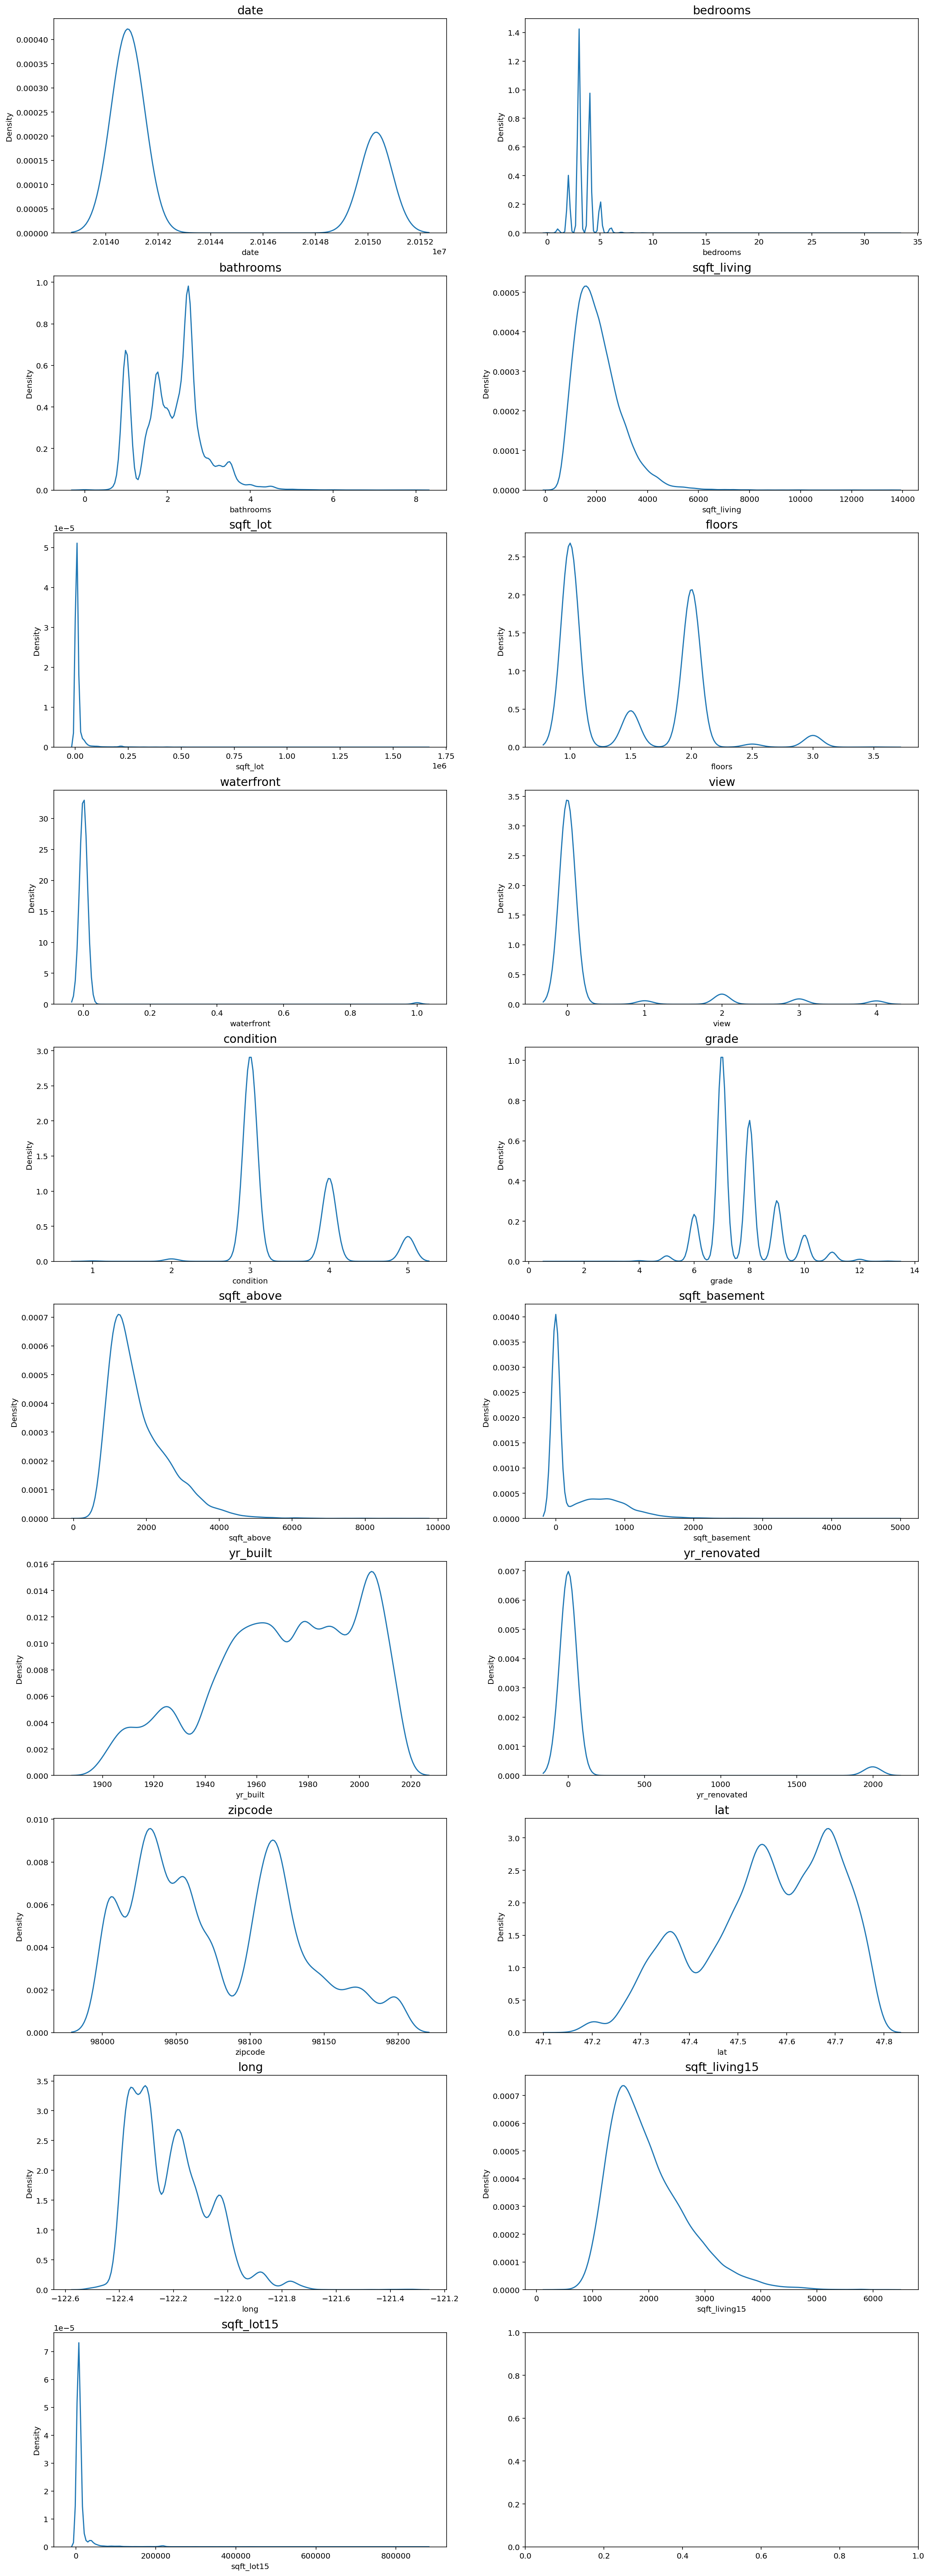

In [17]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

- data 의 각 컬럼값의 분포입니다.
- bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보이고 있으므로, log_scaling 을 통해 정규화합니다.

In [76]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot','sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

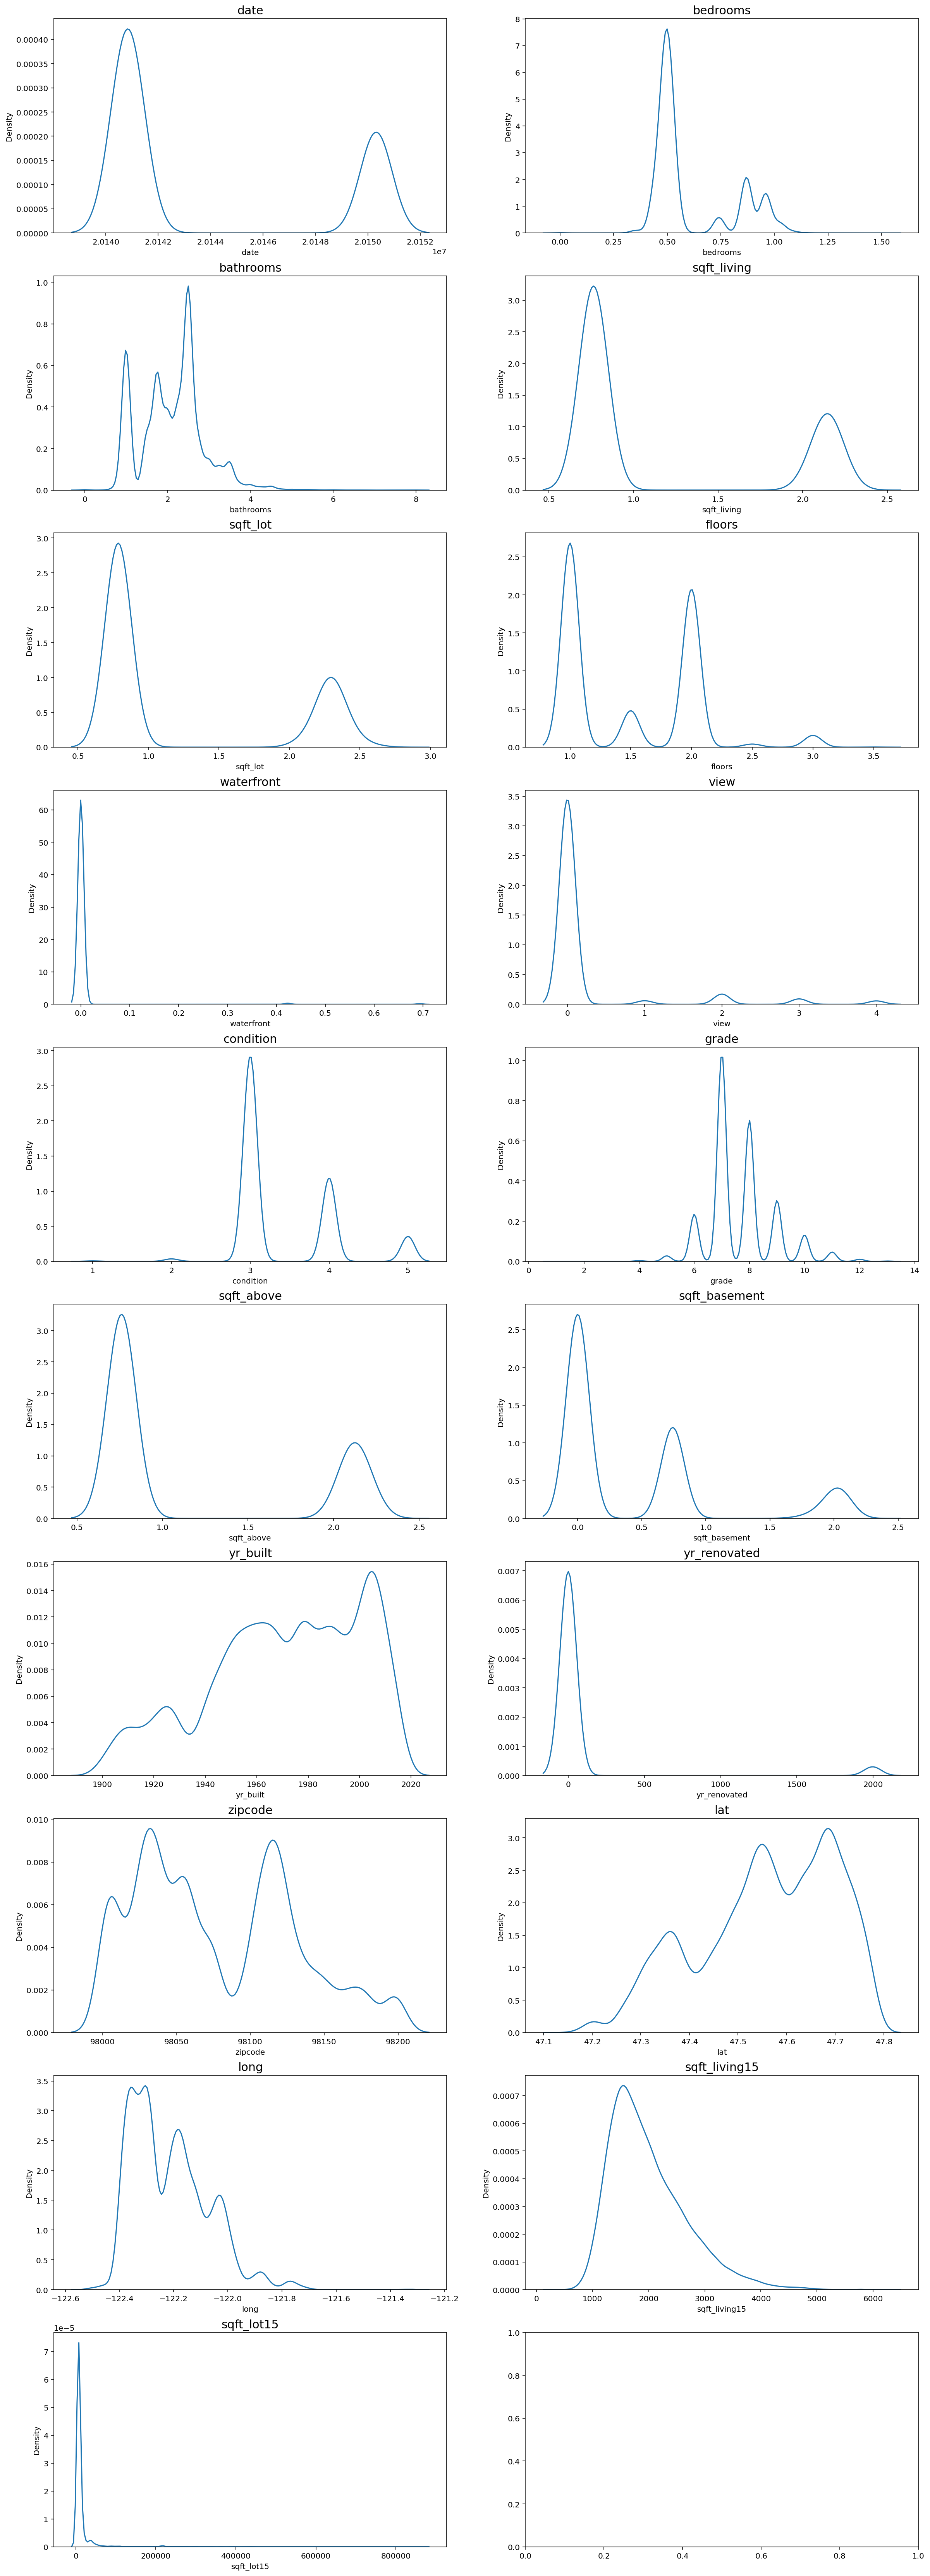

In [23]:
# Test
data = pd.concat((train, test), axis=0)

fig, ax = plt.subplots(10, 2, figsize=(20, 60))

count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19:
            break

- 한쪽으로 치우쳐있었던 컬럼들의 값 분포가 비교적 정규성을 띄고 있습니다.

In [77]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

- 모든 컬럼값이 int 혹은 float type 이므로 학습에 사용할 수 있습니다.

***

### 모델링

In [77]:
# Model 선언
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [78]:
random_state=2019

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

- 각 모델을 선언하고, random-seed 값을 설정해주었습니다.
- 이렇게 선언된 모델들을 List 에 담아주었습니다.

In [79]:
# RMSE 함수
# log 를 취해준 y data 를 exp 로 다시 변환
def rmse(y_val, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_pred)))

- 앞서 우리는 특정 컬럼 데이터에 log 를 취해주었습니다.
- 따라서, validation 데이터와 예측값에 np.expm1() 을 취해주어 원래값으로 복원시켜주어야 합니다.
- 여기서는, np.expm1() 으로 변환한 후, 실제값과 예측값 간 RMSE 를 반환하는 함수를 정의해주었습니다.

In [82]:
# Cross Validation 함수
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

- 모델의 성능을 간단히 평가하는 함수입니다.

In [83]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8796
Model: XGBoost, CV score:0.8973
Model: LightGBM, CV score:0.9025


- 모델 별 결정계수 값을 도출합니다.
- 값이 1 에 가까울수록 모델이 잘 학습되었음을 의미합니다.
- 위에서는 3개 모델 모두 준수한 성능을 보여주고 있습니다.

***

### Test data 학습 및 예측

In [85]:
def AveragingBlending(models, train, y, test):
    for m in models : 
        m['model'].fit(train.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    return np.mean(predictions, axis=1)

- 3개 모델을 모두 학습시킨 후, Test 데이터에 대해 예측합니다.
- 각 모델에 대한 예측 결과를 평균내어주는 함수입니다.

In [88]:
prediction = AveragingBlending(models, train, y, test)

# Test
print(len(y_pred))
y_pred

6468


array([13.14462881, 12.98192758, 14.08443622, ..., 13.02622152,
       12.72060737, 12.98918701])

In [89]:
# 예측값을 exp 로 변환
prediction = np.expm1(prediction)
prediction

array([ 511256.57988094,  434488.72760121, 1308556.86123294, ...,
        454166.5782457 ,  334570.99529514,  437654.35283074])

- 데이터들에 대해 log를 취해주었으므로, expm1 을 다시 취하여 복원시켜줍니다.

***

### 예측한 결과를 csv 파일로 저장

In [92]:
def save_to_csv(prediction, model_name, rmsle=None):    
    # sample_submission.csv
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)

    # prediction 을 sample_submission 의 'price' 컬럼에 덮어씌우기
    submission['price'] = prediction
    submission.head()

    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)

    print('{} saved!'.format(submission_csv_path))

- 예측결과인 prediction, model_name, rmsle 를 인자로 받아 csv 파일로 저장하는 함수입니다.

In [95]:
model_name = 'Ensemble'

save_to_csv(prediction, model_name)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_Ensemble_RMSLE_None.csv saved!


- 각 모델을 학습시킨 후, RMSE 를 도출하여 DataFrame 으로 반환하는 함수입니다.

# 1.3) Source Code

### 데이터 준비

In [195]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [196]:
train.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [197]:
test.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

### 데이터 전처리

In [198]:
for df in [train, test]:
    df['year'] = pd.to_numeric(df.date.str.slice(0, 4))
    df['month'] = pd.to_numeric(df.date.str.slice(4, 6))
    df.drop(['id', 'date'], axis=1, inplace=True)

- date 컬럼에서 연, 월을 잘라내 각각의 컬럼으로 구분하여 주었습니다.
- 학습에 필요하지 않은 id 컬럼과 date 컬럼은 drop 해주었습니다.

In [199]:
train.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  180000.0         2       1.00          770     10000     1.0           0   
2  510000.0         3       2.00         1680      8080     1.0           0   
3  257500.0         3       2.25         1715      6819     2.0           0   
4  291850.0         3       1.50         1060      9711     1.0           0   

   view  condition  grade  ...  sqft_basement  yr_built  yr_renovated  \
0     0          3      7  ...              0      1955             0   
1     0          3      6  ...              0      1933             0   
2     0          3      8  ...              0      1987             0   
3     0          3      7  ...              0      1995             0   
4     0          3      7  ...              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  year  month  
0    98178  47.5112 -122.257           1340        5650  2014     10  
1    98028  47.7379 -122.233           2720        8062  2015      2  
2    98074  47.6168 -122.045           1800        7503  2015      2  
3    98003  47.3097 -122.327           2238        6819  2014      6  
4    98198  47.4095 -122.315           1650        9711  2015      1  

[5 rows x 21 columns]

In [200]:
test.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0         3       2.25         2570      7242     2.0           0     0   
1         4       3.00         1960      5000     1.0           0     0   
2         4       4.50         5420    101930     1.0           0     0   
3         3       1.00         1780      7470     1.0           0     0   
4         3       2.50         1890      6560     2.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7        2170            400      1951          1991   
1          5      7        1050            910      1965             0   
2          3     11        3890           1530      2001             0   
3          3      7        1050            730      1960             0   
4          3      7        1890              0      2003             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  year  month  
0    98125  47.7210 -122.319           1690        7639  2014     12  
1    98136  47.5208 -122.393           1360        5000  2014     12  
2    98053  47.6561 -122.005           4760      101930  2014      5  
3    98146  47.5123 -122.337           1780        8113  2015      4  
4    98038  47.3684 -122.031           2390        7570  2015      3

In [201]:
train = train.astype('float32')
test = test.astype('float32')

- 컬럼들의 연산을 위해 float type 으로 바꾸어주었습니다.

In [202]:
train['yr_renovated'].unique()

array([   0., 2002., 1999., 1991., 1978., 2005., 2008., 2003., 1994.,
       1984., 1954., 2014., 2011., 1974., 1983., 2013., 1990., 1957.,
       1977., 1981., 1995., 2000., 1986., 1992., 2004., 2007., 1987.,
       2006., 1985., 1971., 1945., 1979., 1997., 2010., 1969., 1948.,
       2009., 1970., 2015., 1989., 2001., 1968., 2012., 1963., 1993.,
       1962., 1972., 1980., 1998., 1955., 1996., 1950., 1956., 1982.,
       1988., 1940., 1946., 1975., 1964., 1958., 1976., 1973., 1967.,
       1965., 1944.], dtype=float32)

In [203]:
test['yr_renovated'].unique()

array([1991.,    0., 2010., 1992., 2013., 1994., 1984., 2002., 2005.,
       1945., 1990., 1988., 2014., 1978., 1998., 1970., 1989., 2004.,
       2009., 1973., 2001., 1986., 1980., 2000., 1950., 2006., 1987.,
       2011., 2003., 1951., 2008., 1996., 1999., 1985., 1953., 1979.,
       1993., 1981., 1982., 1997., 1969., 1983., 1995., 2007., 1976.,
       1977., 1940., 1958., 1964., 2012., 1975., 1957., 1959., 1960.,
       2015., 1968., 1934., 1965., 1974., 1972., 1946.], dtype=float32)

- 재건축 연도의 값 중 0 으로 표시된 값은 재건축을 하지 않았다는 의미입니다.
- 재건축 연도와 건축 연도를 활용하여 재건축 여부 컬럼을 생성해주겠습니다.

In [204]:
for df in [train, test]:
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x < 0 else 1)
    
train.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)
test.drop(['yr_built', 'yr_renovated'], axis=1, inplace=True)

print(train.shape)
print(test.shape)

(15035, 20)
(6468, 19)


- 재건축이 된 건물이라면 1, 재건축이 되지 않은 건물이라면 0 으로 표현됩니다.

In [205]:
train.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0       3.0       1.00       1180.0    5650.0     1.0         0.0   
1  180000.0       2.0       1.00        770.0   10000.0     1.0         0.0   
2  510000.0       3.0       2.00       1680.0    8080.0     1.0         0.0   
3  257500.0       3.0       2.25       1715.0    6819.0     2.0         0.0   
4  291850.0       3.0       1.50       1060.0    9711.0     1.0         0.0   

   view  condition  grade  sqft_above  sqft_basement  zipcode        lat  \
0   0.0        3.0    7.0      1180.0            0.0  98178.0  47.511200   
1   0.0        3.0    6.0       770.0            0.0  98028.0  47.737900   
2   0.0        3.0    8.0      1680.0            0.0  98074.0  47.616798   
3   0.0        3.0    7.0      1715.0            0.0  98003.0  47.309700   
4   0.0        3.0    7.0      1060.0            0.0  98198.0  47.409500   

         long  sqft_living15  sqft_lot15    year  month  is_renovated  
0 -122.257004         1340.0      5650.0  2014.0   10.0             0  
1 -122.233002         2720.0      8062.0  2015.0    2.0             0  
2 -122.044998         1800.0      7503.0  2015.0    2.0             0  
3 -122.327003         2238.0      6819.0  2014.0    6.0             0  
4 -122.315002         1650.0      9711.0  2015.0    1.0             0

In [206]:
test.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0       3.0       2.25       2570.0    7242.0     2.0         0.0   0.0   
1       4.0       3.00       1960.0    5000.0     1.0         0.0   0.0   
2       4.0       4.50       5420.0  101930.0     1.0         0.0   0.0   
3       3.0       1.00       1780.0    7470.0     1.0         0.0   0.0   
4       3.0       2.50       1890.0    6560.0     2.0         0.0   0.0   

   condition  grade  sqft_above  sqft_basement  zipcode        lat  \
0        3.0    7.0      2170.0          400.0  98125.0  47.721001   
1        5.0    7.0      1050.0          910.0  98136.0  47.520802   
2        3.0   11.0      3890.0         1530.0  98053.0  47.656101   
3        3.0    7.0      1050.0          730.0  98146.0  47.512299   
4        3.0    7.0      1890.0            0.0  98038.0  47.368401   

         long  sqft_living15  sqft_lot15    year  month  is_renovated  
0 -122.319000         1690.0      7639.0  2014.0   12.0             1  
1 -122.392998         1360.0      5000.0  2014.0   12.0             0  
2 -122.004997         4760.0    101930.0  2014.0    5.0             0  
3 -122.336998         1780.0      8113.0  2015.0    4.0             0  
4 -122.030998         2390.0      7570.0  2015.0    3.0             0

In [207]:
for df in [train, test]:
    df['far1'] = df['sqft_living'] / df['sqft_lot']

- 부지 면적 중 주거 공간이 차지하는 비율을 새로운 컬럼으로 생성합니다.

In [208]:
train['is_ba'] = 0
train.loc[train.loc[train.sqft_basement != 0].index, 'is_ba'] = 1
train.loc[train.loc[train.sqft_basement == 0].index, 'is_ba'] = 0

test['is_ba'] = 0
test.loc[test.loc[test.sqft_basement != 0].index, 'is_ba'] = 1
test.loc[test.loc[test.sqft_basement == 0].index, 'is_ba'] = 0

- 지하실의 여부를 표현하는 컬럼을 생성합니다.
- 지하실이 있을 경우 1, 없을 경우 0 으로 표현됩니다.

In [209]:
train.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0       3.0       1.00       1180.0    5650.0     1.0         0.0   
1  180000.0       2.0       1.00        770.0   10000.0     1.0         0.0   
2  510000.0       3.0       2.00       1680.0    8080.0     1.0         0.0   
3  257500.0       3.0       2.25       1715.0    6819.0     2.0         0.0   
4  291850.0       3.0       1.50       1060.0    9711.0     1.0         0.0   

   view  condition  grade  ...  zipcode        lat        long  sqft_living15  \
0   0.0        3.0    7.0  ...  98178.0  47.511200 -122.257004         1340.0   
1   0.0        3.0    6.0  ...  98028.0  47.737900 -122.233002         2720.0   
2   0.0        3.0    8.0  ...  98074.0  47.616798 -122.044998         1800.0   
3   0.0        3.0    7.0  ...  98003.0  47.309700 -122.327003         2238.0   
4   0.0        3.0    7.0  ...  98198.0  47.409500 -122.315002         1650.0   

   sqft_lot15    year  month  is_renovated      far1  is_ba  
0      5650.0  2014.0   10.0             0  0.208850      0  
1      8062.0  2015.0    2.0             0  0.077000      0  
2      7503.0  2015.0    2.0             0  0.207921      0  
3      6819.0  2014.0    6.0             0  0.251503      0  
4      9711.0  2015.0    1.0             0  0.109155      0  

[5 rows x 22 columns]

In [210]:
test.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0       3.0       2.25       2570.0    7242.0     2.0         0.0   0.0   
1       4.0       3.00       1960.0    5000.0     1.0         0.0   0.0   
2       4.0       4.50       5420.0  101930.0     1.0         0.0   0.0   
3       3.0       1.00       1780.0    7470.0     1.0         0.0   0.0   
4       3.0       2.50       1890.0    6560.0     2.0         0.0   0.0   

   condition  grade  sqft_above  ...  zipcode        lat        long  \
0        3.0    7.0      2170.0  ...  98125.0  47.721001 -122.319000   
1        5.0    7.0      1050.0  ...  98136.0  47.520802 -122.392998   
2        3.0   11.0      3890.0  ...  98053.0  47.656101 -122.004997   
3        3.0    7.0      1050.0  ...  98146.0  47.512299 -122.336998   
4        3.0    7.0      1890.0  ...  98038.0  47.368401 -122.030998   

   sqft_living15  sqft_lot15    year  month  is_renovated      far1  is_ba  
0         1690.0      7639.0  2014.0   12.0             1  0.354874      1  
1         1360.0      5000.0  2014.0   12.0             0  0.392000      1  
2         4760.0    101930.0  2014.0    5.0             0  0.053174      1  
3         1780.0      8113.0  2015.0    4.0             0  0.238286      1  
4         2390.0      7570.0  2015.0    3.0             0  0.288110      0  

[5 rows x 21 columns]

In [212]:
train.drop(['sqft_basement'], axis=1, inplace=True)
test.drop(['sqft_basement'], axis=1, inplace=True)

In [214]:
train['new_grade'] = train['grade'] + train['condition'] + train['view']
test['new_grade'] = train['grade'] + train['condition'] + train['view']

- grade, condition, view 를 더한 새로운 컬럼을 생성해주었습니다.

In [216]:
y = train['price']
del train['price']

# Test
print('train.shape:', train.shape)
print('test.shape:', test.shape)

train.shape: (15035, 21)
test.shape: (6468, 21)


In [217]:
data = pd.concat((train, test), axis=0)
data.shape

(21503, 21)

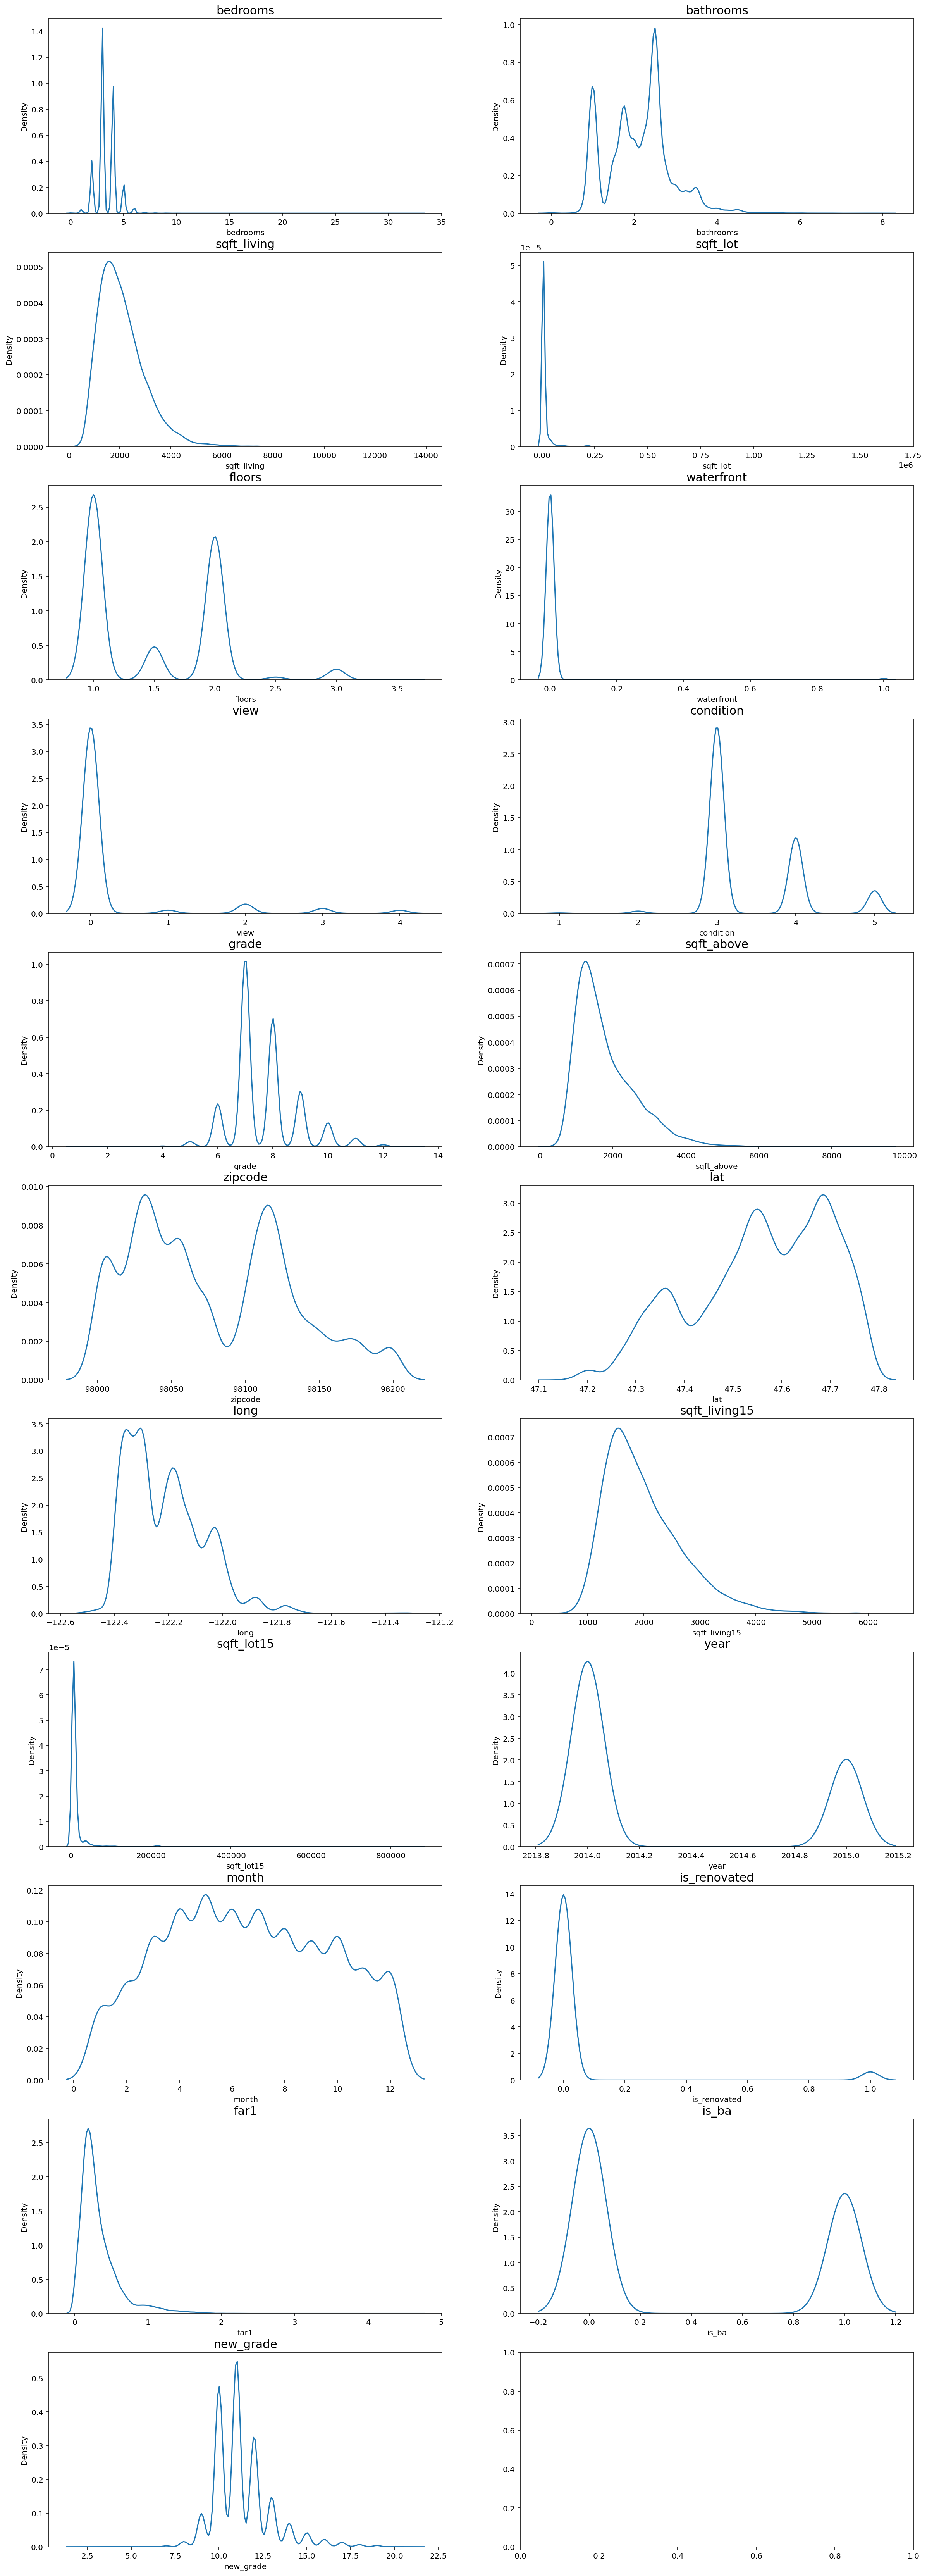

In [218]:
fig, ax = plt.subplots(11, 2, figsize=(20, 60))

count = 0
columns = data.columns
for row in range(11):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 21:
            break

- bedrooms, sqft_living, sqft_lot, sqft_above, sqft_living15, far1 의 데이터가 한쪽으로 치우친 경향을 보이고 있습니다.

In [219]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot','sqft_above', 'sqft_living15', 'far1']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    
for c in skew_columns:
    test[c] = np.log1p(test[c].values)

In [220]:
data = pd.concat((train, test), axis=0)
data.shape

(21503, 21)

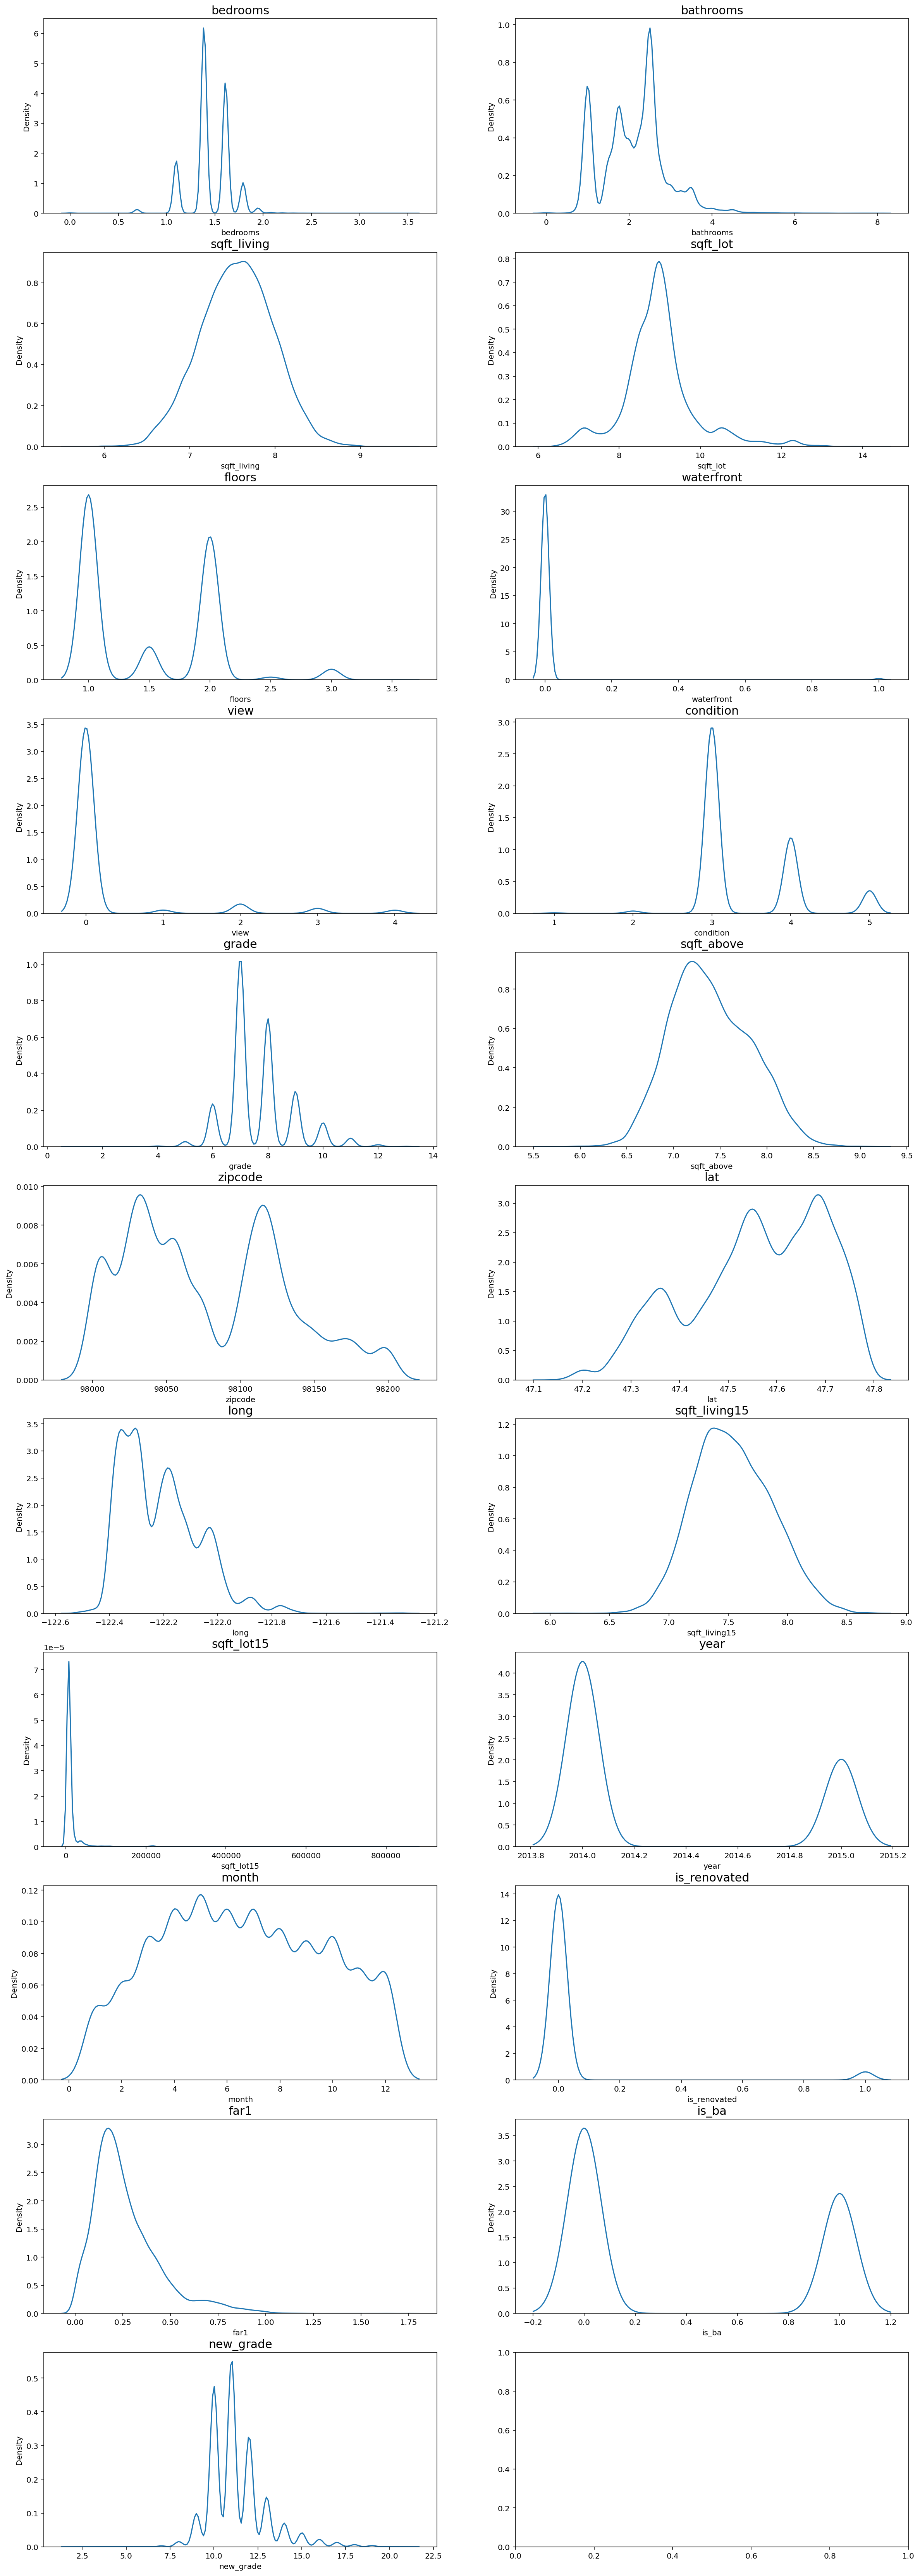

In [221]:
fig, ax = plt.subplots(11, 2, figsize=(20, 60))

count = 0
columns = data.columns
for row in range(11):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 21:
            break

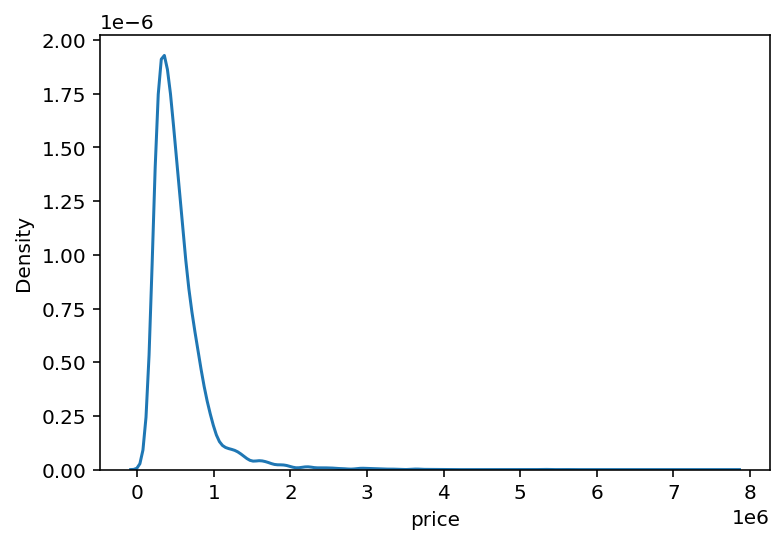

In [223]:
sns.kdeplot(y)
plt.show()

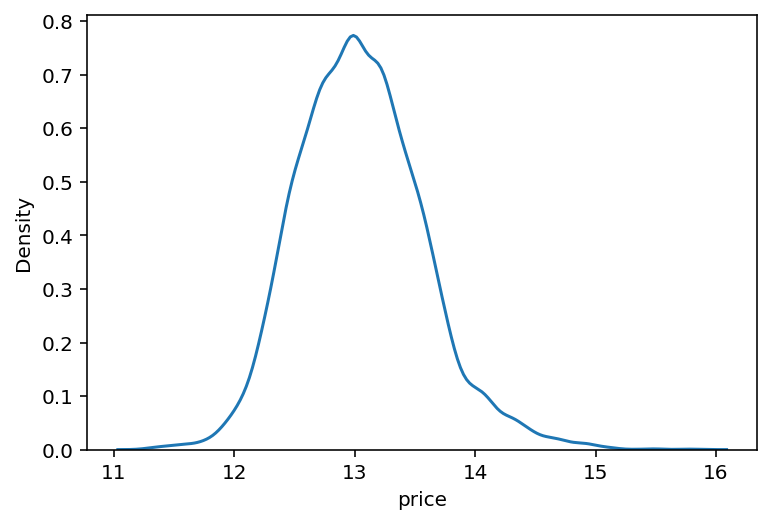

In [224]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

- target 변수인 price 에 대해서도 log 를 취해주었습니다.

In [225]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       15035 non-null  float32
 1   bathrooms      15035 non-null  float32
 2   sqft_living    15035 non-null  float32
 3   sqft_lot       15035 non-null  float32
 4   floors         15035 non-null  float32
 5   waterfront     15035 non-null  float32
 6   view           15035 non-null  float32
 7   condition      15035 non-null  float32
 8   grade          15035 non-null  float32
 9   sqft_above     15035 non-null  float32
 10  zipcode        15035 non-null  float32
 11  lat            15035 non-null  float32
 12  long           15035 non-null  float32
 13  sqft_living15  15035 non-null  float32
 14  sqft_lot15     15035 non-null  float32
 15  year           15035 non-null  float32
 16  month          15035 non-null  float32
 17  is_renovated   15035 non-null  int64  
 18  far1  

***

### 하이퍼 파라미터 및 모델링

In [333]:
# Model 선언
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [324]:
def print_best_params(model, params):
    grid_model = GridSearchCV(
        model, 
        param_grid = params,
        cv=5,
        scoring='neg_mean_squared_error')

    grid_model.fit(train, y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값 {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

- 최적의 파라미터를 찾아주는 함수입니다.

In [325]:
xgb_params ={
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.9],
    'colsample_bytree': [0.5],
    'gpu_id':[0] ,         
    'tree_method':['gpu_hist'],
    'predictor':['gpu_predictor'],
    'n_estimators':[1000],
}

In [327]:
xgboost = XGBRegressor(random_state=2022)
xgb_estimator = print_best_params(xgboost, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 0.1623, 최적 alpha:{'colsample_bytree': 0.5, 'gpu_id': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 1000, 'predictor': 'gpu_predictor', 'subsample': 0.9, 'tree_method': 'gpu_hist'}


In [328]:
lgb_params = {
    'n_estimators':[250, 1000],
    'max_depth' : [40, 80]
}

In [329]:
model = LGBMRegressor(random_state=2022)
my_GridSearch(model, train, y, lgb_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


max_depth  n_estimators     score     RMSLE
0         40           250 -0.027286  0.165184
2         80           250 -0.027286  0.165184
1         40          1000 -0.028121  0.167693
3         80          1000 -0.028121  0.167693

***

### Test data 학습 및 예측

In [336]:
xgb_preds = xgb_estimator.predict(test)
xgb_preds = np.expm1(xgb_preds)
xgb_preds.shape

(6468,)

In [337]:
model = LGBMRegressor(max_depth=40, n_estimators=250, 
                      random_state=2022)

model.fit(train, y)
prediction = model.predict(test)
lgb_preds = np.expm1(predictions)
lgb_preds.shape

(6468,)

In [338]:
xgb_preds

array([ 531891.4 ,  427922.88, 1086976.5 , ...,  568758.  ,  255411.69,
        551165.06], dtype=float32)

In [339]:
lgb_preds

array([ 566317.42209966,  392995.92305401, 1022593.16051645, ...,
        532619.20214051,  291984.80591433,  562669.18390796])

In [341]:
prediction = 0.5 * xgb_preds + 0.5 * lgb_preds
prediction

array([ 549104.39854983,  410459.39902701, 1054784.83025822, ...,
        550688.60107026,  273698.24670717,  556917.12320398])

***

### 예측한 결과를 csv 파일로 저장

In [342]:
model_name = 'XgbLgbEnsemble'

save_to_csv(prediction, model_name)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_XgbLgbEnsemble_RMSLE_None.csv saved!
